In [1]:
from citrination_client import CitrinationClient
from os import environ
client = CitrinationClient(environ['CITRINATION_API_KEY'], 'https://citrination.com')

In [2]:
def enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu):
    return (energy - n_Al * energy_Al - n_Cu * energy_Cu) / (n_Al + n_Cu)

In [3]:
import re
def get_stoich(AlCu_formula):
    m = re.match(r"Al([0-9]*)Cu([0-9]*)", AlCu_formula)
    if m is not None:
        n_Al = float(m.group(1)) if len(m.group(1)) > 0 else 1
        n_Cu = float(m.group(2)) if len(m.group(2)) > 0 else 1
        return (n_Al, n_Cu)
    m = re.match(r"Cu([0-9]*)Al([0-9]*)", AlCu_formula)
    if m is not None:
        n_Cu = float(m.group(1)) if len(m.group(1)) > 0 else 1
        n_Al = float(m.group(2)) if len(m.group(2)) > 0 else 1
        return (n_Al, n_Cu)
    return (0, 0)

# Advanced Queries

Writing analysis and post-processing on top of PIFs lets us:
 1. Pull in data from collaborators and published sources
 1. Share our methodology with other researchers with data in PIFs

Let's actually do that!

## Real example: phase stability diagram

There are surely more Al-Cu binaries on Citrination.  We will:
 1. Find relevant data via the web interface
 2. Filter the data programatically with the query
 3. Extract the data using query extractions
 4. Add the data to our plot from before

## Search for relevant data

The exploratory search is usually best done on the website.  Tips and tricks:
 * "AlxCuy" searches for any Al-Cu binary
 * "energy" searches for properties with "energy" in their name

## Adding filters to the query

Now that we are querying beyond just our data, we need to filter down to records that contain Al-Cu energies.

### Filter by chemical formula

In [4]:
from citrination_client import PifSystemReturningQuery, PifSystemQuery, FieldQuery, ValueQuery
from citrination_client import PropertyQuery, DataQuery, DatasetQuery, ChemicalFieldQuery, ChemicalFilter, Filter


query = PifSystemReturningQuery(
            size=500,
            query=DataQuery(
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        extract_as="formula",
                        filter=ChemicalFilter(equal='AlxCuy'),
                    )
                )
            ))

query_result = client.search(query)

print("Found {} PIFs".format(query_result.total_num_hits))

Found 133 PIFs


### Filter by property

In [5]:
query = PifSystemReturningQuery(
            size=500,
            query=DataQuery(
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        extract_as="formula",
                        filter=ChemicalFilter(equal='AlxCuy'),
                    ),
                    properties=PropertyQuery(
                        name=FieldQuery(
                            filter=[Filter(equal="Formation energy"), Filter(equal="Enthalpy of Formation")]),
                        value=FieldQuery(
                            extract_as="formation_enthalpy")
                    )
                )
            ))

query_result = client.search(query)
print("Found {} PIFs".format(query_result.total_num_hits))

Found 16 PIFs


In [6]:
from pypif.pif import dumps
print(dumps(query_result.hits[1].system, indent=2))

{
  "category": "system.chemical",
  "references": [
    {
      "doi": "10.1016/j.commatsci.2012.02.002"
    },
    {
      "doi": "10.1016/j.commatsci.2012.02.005"
    }
  ],
  "uid": "5CA6B3488E258DB2E0A73ADDA2F97C4D",
  "properties": [
    {
      "name": "Structure designation",
      "scalars": [
        {
          "value": "CaF[2]"
        }
      ]
    },
    {
      "name": "Formation energy",
      "scalars": [
        {
          "value": "-0.1799"
        }
      ],
      "units": "eV/atom",
      "dataType": "COMPUTATIONAL"
    }
  ],
  "chemicalFormula": "CuAl2"
}


## Extract data from results using the query language

Multiple sources typically use multiple internal formats.  The query language is smart about crawling the PIFs for properties with the right names, while `pypif` is not.  Fortunately, you can use the query language to do data extraction as well!

### Using `extract_as`

In [7]:
query = PifSystemReturningQuery(
            size=500,
            query=DataQuery(
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        extract_as="formula",
                        filter=ChemicalFilter(equal='AlxCuy'),
                    ),
                    properties=PropertyQuery(
                        name=FieldQuery(
                            filter=[Filter(equal="Formation energy"), Filter(equal="Enthalpy of Formation")]),
                        value=FieldQuery(
                            filter=[Filter(min=-1.0), ],
                            extract_as="formation_enthalpy")
                    )
                )
            ))

query_result = client.search(query)
print("Found {} PIFs".format(query_result.total_num_hits))

print([x.extracted for x in query_result.hits[:3]])

Found 16 PIFs
[{'formation_enthalpy': '-0.1889', 'formula': 'Cu3Al'}, {'formation_enthalpy': '-0.1799', 'formula': 'CuAl2'}, {'formation_enthalpy': '-0.1288', 'formula': 'Cu5Al'}]


A few notes:
 * `extract_as` extracts the field it is on (why we need value)
 * `extracted` is a dictionary from String keys to values; no units or uncertainty

## Real example: phase stability diagram

Let's add these points to our Al-Cu phase diagram.

In [8]:
new_points = []
for hit in query_result.hits:
    n_Al, n_Cu = get_stoich(hit.extracted["formula"])
    new_points.append((
            n_Cu / (n_Cu + n_Al),
            float(hit.extracted["formation_enthalpy"])
        ))

Text(0,0.5,'$\\Delta H (eV/atom)$')

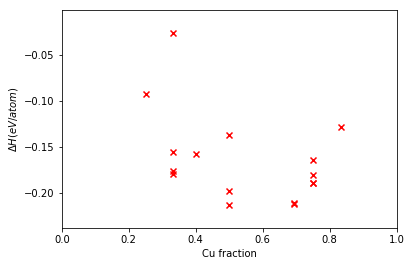

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(*zip(*new_points), color='red', marker='x')
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H (eV/atom)$")